## Face Recognition - 02/06/2020

Identify multiple faces in one image.

In [99]:
import cv2

In [111]:
import tensorflow as tf
import pathlib
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
data_dir='./cropped/train/'   #path of training directory
data_dir = pathlib.Path(data_dir)

data_dr='./cropped/valid/'    #path of valid_set directory
data_dr = pathlib.Path(data_dr)

image_count = len(list(data_dir.glob('*/*.jpg')))

# generator for training set and valid set. The training data generator employs data augmentation in form of flips and zooms.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [113]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# name of classes
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Anne_Hathaway', 'Ayushmann_Khurrana', 'Brad_Pitt', 'Irrfan_Khan',
       'Jen_Aniston', 'Jen_Lawrence', 'Johnny_Depp', 'Pankaj_Tripathi',
       'Robert_DowneyJr', 'Will_Smith'], dtype='<U18')

In [114]:
#iterable form of generators

train_data_gen = train_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

valid_data_gen = image_generator.flow_from_directory(directory=str(data_dr),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1295 images belonging to 10 classes.
Found 358 images belonging to 10 classes.


In [115]:
images,labels=next(train_data_gen)
x_test,y_test=next(valid_data_gen)

In [116]:
#defining the model 

num_classes = 10
input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#compliling the model

model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

In [153]:

# training the model upto a satisfying value of accuracy as well as val_accuracy

h = model.fit(train_data_gen, steps_per_epoch=STEPS_PER_EPOCH, epochs=20, 
              verbose=1, validation_data=valid_data_gen, validation_steps=41)

Epoch 1/20
41/41 [==============================] - 149s 4s/step - loss: 0.7720 - accuracy: 0.7081 - val_loss: 0.7310 - val_accuracy: 0.9530
Epoch 2/20
41/41 [==============================] - 135s 3s/step - loss: 0.7599 - accuracy: 0.7042 - val_loss: 0.1524 - val_accuracy: 0.9660
Epoch 3/20
41/41 [==============================] - 135s 3s/step - loss: 0.7355 - accuracy: 0.7205 - val_loss: 0.0812 - val_accuracy: 0.9768
Epoch 4/20
41/41 [==============================] - 136s 3s/step - loss: 0.7766 - accuracy: 0.6896 - val_loss: 0.1328 - val_accuracy: 0.9530
Epoch 5/20
41/41 [==============================] - 144s 4s/step - loss: 0.7173 - accuracy: 0.7097 - val_loss: 0.1517 - val_accuracy: 0.9743
Epoch 6/20
41/41 [==============================] - 137s 3s/step - loss: 0.7134 - accuracy: 0.7290 - val_loss: 0.0830 - val_accuracy: 0.9708
Epoch 7/20
41/41 [==============================] - 142s 3s/step - loss: 0.6907 - accuracy: 0.7483 - val_loss: 0.2136 - val_accuracy: 0.9716
Epoch 8/20
41

In [154]:
model.save('./model_0206.h5')

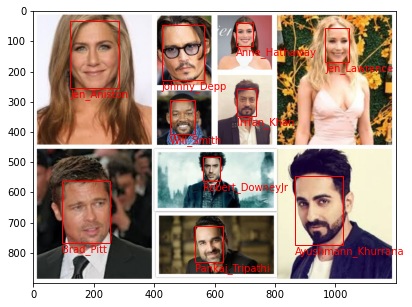

In [155]:
#identifying multiple celebrities in an image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
from skimage import transform
from keras.preprocessing import image
from keras.models import load_model

model=load_model('./model_0206.h5')
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# draw each face separately
def draw_faces(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    fig, axes = pyplot.subplots(1,1, figsize=(10, 5))
    axes.imshow(data)
    h,w,c=data.shape
    # plot each face as a subplot
    for i in range(len(result_list)):
        # get coordinates
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        np_image = data[y1:y2,x1:x2]
        np_image = np.array(np_image).astype('float32')/255
        np_image = transform.resize(np_image, (224, 224, 3))
        img = np.expand_dims(np_image, axis=0)
        img_class=model.predict(img) 
        dist=np.max(img_class)
        cls=np.argmax(img_class)
        rect = patches.Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
        pyplot.text(x1, y2+30,CLASS_NAMES[cls], fontsize=10,color='r')
        axes.add_patch(rect)
    # show the plot
    pyplot.show()

    
filename = './images/check/collage.jpg'
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_faces(filename, faces)

In [156]:
import os
from keras.models import load_model
import cv2

# path to test files
test_dirpath = os.path.join('./images/test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

face = './model/cv2/data/haarcascade_frontalface_default.xml' # contains the path to the cv2 model file

facer = cv2.CascadeClassifier(face)

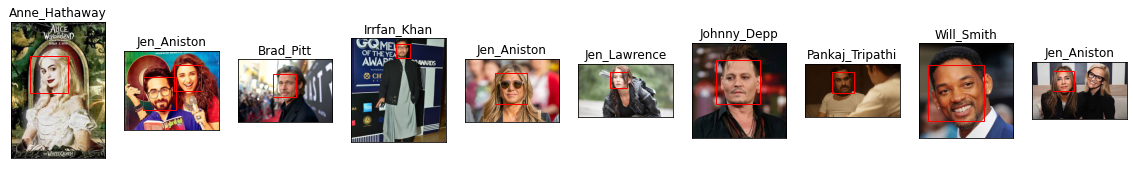

In [157]:
from PIL import Image
import numpy as np
from skimage import transform
from keras.preprocessing import image
from mtcnn.mtcnn import MTCNN

model=load_model('./model_0206.h5')
# load the file in array format
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image


aligned_images = [] 
classes=[]

# predict the class of the image
for i in range(len(test_filepaths)):
    img=load(test_filepaths[i])
    img_class=model.predict_classes(img)
    prediction = img_class[0]
    classes.append(img_class[0])


import matplotlib.patches as patches
from imageio import imread
import cv2

fig, axes = plt.subplots(1, len(test_filepaths), figsize=(20, 5))

margin=10       
        
for i in range(len(test_filepaths)): 
    axes[i].set_title((CLASS_NAMES[classes[i]]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    img = imread(test_filepaths[i])
    faces= facer.detectMultiScale(img,scaleFactor=1.1,minNeighbors=5,minSize=(10, 10),flags=cv2.CASCADE_SCALE_IMAGE)
    for face in faces:
        (x, y, w, h)=face
        cropped = img[y-margin//2:y+h-margin//2,
                      x-margin//2:x+w-margin//2, :]
        (w,h,z)=cropped.shape
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axes[i].add_patch(rect)
    
    
plt.show()

In [158]:
from sklearn.metrics import accuracy_score,f1_score

y = ['Anne_Hathaway', 'Ayushmann_Khurrana','Brad_Pitt','Irrfan_Khan','Jen_Aniston',
     'Jen_Lawrence','Johnny_Depp','Pankaj_Tripathi','Will_Smith','Jen_Aniston']
pred=[]
for i in range(len(classes)):
    pred.append(CLASS_NAMES[classes[i]])

print(accuracy_score(y,pred))
print(f1_score(y,pred,average='weighted'))

0.9
0.86


The accuracy of the training set is: 0.76

The accuracy of the validation set is: 0.97

The accuracy of the test set is: 0.9
